# Plotting tiled landcover data from MODIS

Requires ```gdal```, ```osr```, and ```cartopy```.  Install via:

    conda install -c conda-forge cartopy gdal

Note ```osr``` should install itself along with ```gdal```.

In [1]:
import numpy as np
import gdal
import osr
import glob # to inspect files in a folder
import re # for regular expression matching

import cartopy
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.cm as mcm

**List all the files in the proper tile arrangement:**

In [2]:
!ls ../data/satellite-data/modis-landcover-MCD12Q1.006/*h{28,29,30,31,32}*v{08,09,10}*.hdf

../data/satellite-data/modis-landcover-MCD12Q1.006/MCD12Q1.A2001001.h28v08.006.2018053232525.hdf
../data/satellite-data/modis-landcover-MCD12Q1.006/MCD12Q1.A2001001.h28v09.006.2018053232500.hdf
../data/satellite-data/modis-landcover-MCD12Q1.006/MCD12Q1.A2001001.h28v10.006.2018053232813.hdf
../data/satellite-data/modis-landcover-MCD12Q1.006/MCD12Q1.A2001001.h29v08.006.2018054000010.hdf
../data/satellite-data/modis-landcover-MCD12Q1.006/MCD12Q1.A2001001.h29v09.006.2018054000114.hdf
../data/satellite-data/modis-landcover-MCD12Q1.006/MCD12Q1.A2001001.h29v10.006.2018054000142.hdf
../data/satellite-data/modis-landcover-MCD12Q1.006/MCD12Q1.A2001001.h30v08.006.2018054000410.hdf
../data/satellite-data/modis-landcover-MCD12Q1.006/MCD12Q1.A2001001.h30v09.006.2018054000412.hdf
../data/satellite-data/modis-landcover-MCD12Q1.006/MCD12Q1.A2001001.h30v10.006.2018054000515.hdf
../data/satellite-data/modis-landcover-MCD12Q1.006/MCD12Q1.A2001001.h31v08.006.2018054000742.hdf
../data/satellite-data/modis-l

**Create a list of the tiles of interest (here, focusing on Indonesia), then optn them with ```gdal```:**

In [3]:
file_list_all = sorted(glob.glob('../data/satellite-data/modis-landcover-MCD12Q1.006/*2001001*.hdf'))
reg_exp = re.compile('.*h(27|28|29|30|31|32)v(08|09|10)(.*\.hdf)$')
file_list = [filename for filename in file_list_all if re.match(reg_exp, filename)]
gdal_datasets = [gdal.Open(f) for f in file_list]
gdal_lc_type1 = [ds.GetSubDatasets()[0][0] for ds in gdal_datasets]

**Use a VRT (virtual dataset) that tells Python how to mosaic the inputs.**  

* This can be done using the ```gdal``` command line interface
* From the folder where your HDF files are stored, type:


    gdalbuildvrt gdal_landcover_mosaic.vrt *.hdf

The output will be a ```.vrt``` file that instructs Python's ```gdal``` package how to tile the images together.

**NOTE:  The ```gdal``` library and the ```gdalbuildvrt``` function should have been installed last week (week6) with ```geopandas```.  If your terminal shell doesn't recognize it, you can install it via:**

    conda install -c conda-forge gdal

In [4]:
lc_mosaic = gdal.BuildVRT('../data/satellite-data/modis-landcover-MCD12Q1.006/gdal_landcover_mosaic.vrt', gdal_lc_type1)
lc_mosaic_data = np.array(lc_mosaic.ReadAsArray(), dtype=np.float)
lc_mosaic_data_2001 = np.copy(lc_mosaic_data)

**Now the mosaic exists.  Get the geographic transform information using the ```.GetGeoTransform()``` method as before:**

In [5]:
lc_geotrans = lc_mosaic.GetGeoTransform()

**Use the geotransform info to create a data_extent tuple for use in ```cartopy``` plotting syntax:**

In [6]:
data_extent = (lc_geotrans[0], \
               lc_geotrans[0] + lc_mosaic.RasterXSize*lc_geotrans[1], \
               lc_geotrans[3] + lc_mosaic.RasterYSize*lc_geotrans[5], \
               lc_geotrans[3])

**Now prepare logical color maps based on the MODIS land cover type.**  
Info available here:  https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mcd12q1_v006

In [7]:
modis_type_dict = {}
modis_type_dict['1'] = 'Evergreen needleleaf forest'
modis_type_dict['2'] = 'Evergreen broadleaf forest'
modis_type_dict['3'] = 'Deciduous needleleaf forest'
modis_type_dict['4'] = 'Deciduous broadleaf forest'
modis_type_dict['5'] = 'Mixed forest'
modis_type_dict['6'] = 'Closed shrublands'
modis_type_dict['7'] = 'Open shrublands'
modis_type_dict['8'] = 'Woody savannas'
modis_type_dict['9'] = 'Savannas'
modis_type_dict['10'] = 'Grasslands'
modis_type_dict['11'] = 'Permanent wetlands'
modis_type_dict['12'] = 'Croplands'
modis_type_dict['13'] = 'Urban and built-up'
modis_type_dict['14'] = 'Cropland/natural veg. mosaic'
modis_type_dict['15'] = 'Snow and ice'
modis_type_dict['16'] = 'Barren or sparsely vegetated'
modis_type_dict['17'] = 'Water'
#modis_type_dict['255'] = 'Fill Value'

**Create a list of the numbers and corresponding names of the land use categories:**

In [8]:
type_numbers = np.arange(1,18,dtype=np.int)
type_name = [modis_type_dict[str(i)] for i in type_numbers]

**Pick out gradients 

In [9]:
human_cmap = mcm.YlOrRd_r #Purples
water_cmap = mcm.Blues
veg_cmap = mcm.Greens_r
shrub_cmap = mcm.pink #YlOrBr

svals = np.linspace(0.2,0.85,5)
vvals = np.linspace(0.2,0.85,5) # for vegetation categories
hvals = [0.25,0.5,0.75] # for human categories

colors_list = [veg_cmap(vvals[0]),veg_cmap(vvals[1]),veg_cmap(vvals[2]),veg_cmap(vvals[3]),veg_cmap(vvals[4]),
               shrub_cmap(svals[0]),shrub_cmap(svals[1]),shrub_cmap(svals[2]),shrub_cmap(svals[3]),shrub_cmap(svals[4]),
               water_cmap(0.5),
               human_cmap(hvals[0]),human_cmap(hvals[1]),human_cmap(hvals[2]),
               '0.7','0.9',water_cmap(0.75)]

categorical_cmap = matplotlib.colors.ListedColormap(colors_list, name='None')

norm = matplotlib.colors.BoundaryNorm(np.arange(type_numbers.min()-0.5,type_numbers.max()+0.5+1,1),\
                                                   categorical_cmap.N)

**Create a practice plot to see if our color bar works:**

In [10]:
plot_array = np.random.randint(low=1, high=17, size=(10,10))

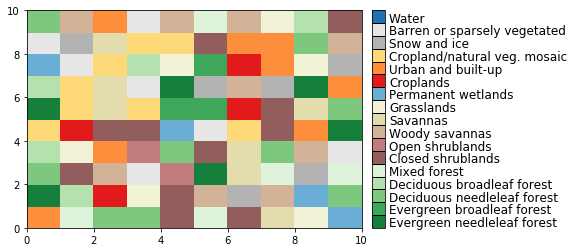

In [11]:
fontsize=12

fig = plt.figure()

ax = fig.add_subplot(111)

landuse_map = ax.pcolormesh(plot_array, cmap=categorical_cmap, norm=norm, vmin=1, vmax=17)

ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1+0.025,ax_pos.y0,0.03,ax_pos.height])
cbar = fig.colorbar(landuse_map, cax=cbar_ax, drawedges=True)
cbar.dividers.set_color('0')
cbar.dividers.set_linewidth(1)
cbar.set_ticks(type_numbers)
cbar.set_ticklabels(type_name)
cbar.ax.tick_params(labelsize=fontsize, length=0)

**Now use this color map on the original projection:**

In [12]:
field = lc_mosaic_data_2001
field[field==255] = np.nan

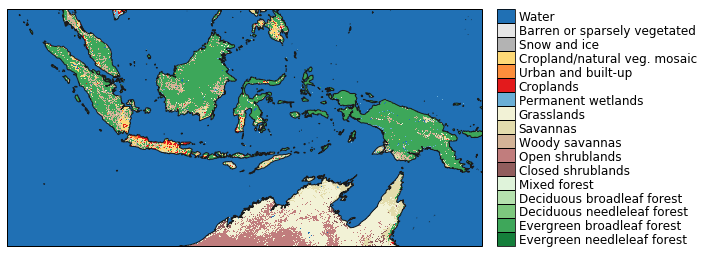

In [13]:
modis_globe = cartopy.crs.Globe(datum='WGS84', ellipse='sphere', semimajor_axis=6371007.181)
map_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
data_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
geodetic_proj = cartopy.crs.Geodetic()

fig = plt.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
image = ax.imshow(field, \
                  extent=data_extent, \
                  origin='upper', transform=data_proj, \
                  vmin=1,vmax=17,norm=norm,\
                  cmap=categorical_cmap)
ax.coastlines(resolution='10m', color='0.1')

#ax.set_global()

ax_pos = ax.get_position()
cbar_ax = fig.add_axes([ax_pos.x1+0.025,ax_pos.y0,0.03,ax_pos.height])
cbar = fig.colorbar(image, cax=cbar_ax, drawedges=True)
cbar.dividers.set_color('0')
cbar.dividers.set_linewidth(1)
cbar.set_ticks(type_numbers)
cbar.set_ticklabels(type_name)
cbar.ax.tick_params(labelsize=fontsize, length=0)